In [18]:
import os,sys

# 1) add FLaPE-Byrd repository location (pulled from github.com/mikedurand/flape-byrd) to the path
sys.path.append('/Users/kyliewadkowski/Desktop/GitHub/FLaPE-Byrd') 

# 2) import needed modules
from ReachObservations import ReachObservations
from ReachTruth import ReachTruth
from RiverIO import RiverIO
from FlowLawCalibration import FlowLawCalibration
from Domain import Domain
from pprint import pprint
from FlowLaws import MWACN,MWAPN,AHGW,AHGD,MWHCN,MWAVN,MOMMA

import pandas as pd
import numpy as np

from IPython.display import display, Markdown

import matplotlib.pyplot as plt

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

In [19]:
#sys.path.remove('/Users/kyliewadkowski/Desktop/OSU_Summer_Research/FLaPE-Byrd-main_old')

In [20]:
# 3) provide path to data folders and read directory contents

DataDir='/Users/kyliewadkowski/Desktop/OSU_Summer_Research/arctic-dem-Q-notebooks-and-data/data/reach_averages/'

IncludeList=['gage98']
RiverNames=['Liard']

**Running gage98**

`xtol` termination condition is satisfied.
Number of iterations: 86, function evaluations: 980, CG iterations: 76, optimality: 3.50e-04, constraint violation: 0.00e+00, execution time: 0.32 s.
height-width fit for set breakpoints


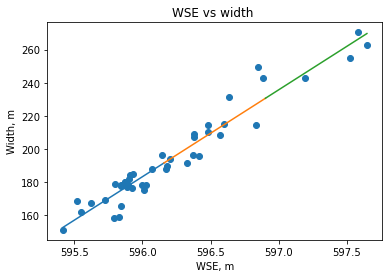

SWOT-style area calculations
Qtrue= [1179.496     983.418189 1049.714979  589.417387  349.935483  250.048693
  281.160297  293.809213  280.033016  282.760474  266.773627  261.021762
  277.009424  272.616     262.584    1758.892711  751.331161  716.124809
  788.129459  721.922579  567.415925  463.411476  374.754097  349.201929
  324.541016  344.922189 1702.656     652.306139  617.033172  601.153676
  435.486041  384.291118  335.415967  355.723488 1827.51237   714.19614
  502.688192  381.650106  357.305159  348.941074 1546.541436  739.273459
  574.939049  487.412039]
width= [236.9919221  224.23808981 245.1335819  200.44040141 180.18319887
 168.41548937 175.99267721 150.7521055  176.63411365 169.72716522
 164.36749667 159.82622073 162.51055078 164.44875949 165.74179826
 239.44922007 221.12524074 209.5237898  211.72287739 206.18534676
 177.4674591  177.620412   187.23701307 181.07810814 179.18553736
 175.35080953 269.63381951 205.12988851 210.8995567  190.82102341
 195.94931663 177.8681679

Constant-n

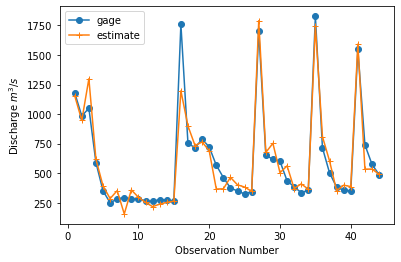

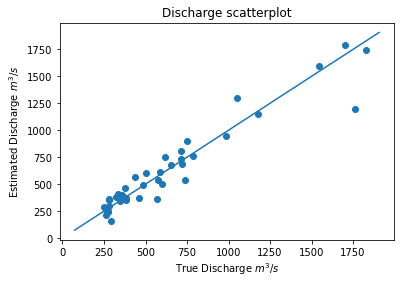

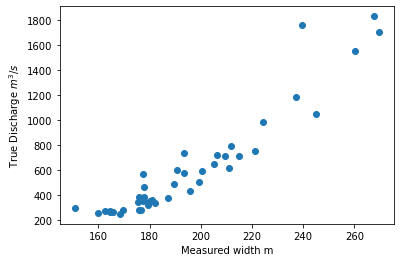

In [22]:
DataDirContents=os.scandir(DataDir)

ConstrainHW=True #set to true to compute self-constrained height-width data
CalcAreaFit=1 # set to 1 for the quicker option - use equally-spaced HW breakpoints
dAOpt=1 #set to 0 to use MetroMan-style. set to 1 to use SWOT style
Verbose=True
ShowEverything=True

RunData={}

for entry in DataDirContents:
    if entry.is_dir() and entry.name in IncludeList:        
        BaseDir=DataDir + entry.name + '/'
        
        display(Markdown("**Running "+entry.name+"**"))
        
        IncludeList.index(entry.name)
        RiverName=RiverNames[IncludeList.index(entry.name)]        
        
        #4) Read data and set up data objects
        IO=RiverIO('MetroManTxt',obsFname=BaseDir+'SWOTobs.txt',truthFname=BaseDir+'truth.txt')        
        D=Domain(IO.ObsData)
        Obs=ReachObservations(D,IO.ObsData,ConstrainHW,CalcAreaFit,dAOpt,Verbose)
        Truth=ReachTruth(IO.TruthData)
                
#         Variants=['AHGW', 'AHGD','HeightManning','Constant-n','PowerLaw-n','MWAVN','MOMMA']        
        Variants=['Constant-n']        
        
        ReachDict={}
        ReachDict['dA']=Obs.dA[0,:]
        ReachDict['w']=Obs.w[0,:]
        ReachDict['S']=Obs.S[0,:]
        ReachDict['H']=Obs.h[0,:]            
        ReachDict['Qtrue']=Truth.Q[0,:]

        FlowLawVariants={}
        FlowLawVariants['AHGW']=AHGW(ReachDict['dA'],ReachDict['w'],ReachDict['S'],ReachDict['H'])           
        FlowLawVariants['AHGD']=AHGD(ReachDict['dA'],ReachDict['w'],ReachDict['S'],ReachDict['H'])          
        FlowLawVariants['HeightManning']=MWHCN(ReachDict['dA'],ReachDict['w'],ReachDict['S'],ReachDict['H'])
        FlowLawVariants['Constant-n']=MWACN(ReachDict['dA'],ReachDict['w'],ReachDict['S'],ReachDict['H'])           
        FlowLawVariants['PowerLaw-n']=MWAPN(ReachDict['dA'],ReachDict['w'],ReachDict['S'],ReachDict['H'])          
        FlowLawVariants['MWAVN']=MWAVN(ReachDict['dA'],ReachDict['w'],ReachDict['S'],ReachDict['H'])  
        FlowLawVariants['MOMMA']=MWAVN(ReachDict['dA'],ReachDict['w'],ReachDict['S'],ReachDict['H'])                                       
        
        cal={} #make a dictionary of results, keyed off the flow law variant name
        for variant in Variants:               
            flow_law_cal=FlowLawCalibration(D,ReachDict['Qtrue'],FlowLawVariants[variant])
            flow_law_cal.CalibrateReach(verbose=False,suppress_warnings=True)
            cal[variant]=flow_law_cal      

            if ShowEverything:
                display(Markdown(variant))
                cal[variant].PlotTimeseries()
                cal[variant].PlotScatterplot()
                cal[variant].PlotScatterQW()
                                    
        #8 Collect run data
        ThisRunData={
           "id":entry.name,                          
           "cal":cal
        }
        RunData[RiverName]=ThisRunData            

In [16]:
# use finite-difference to check jacobian at initial parameters
flow_law_cal.CalibrateReach(verbose=False,suppress_warnings=True)

Qtrue= [1179.496     983.418189 1049.714979  589.417387  349.935483  250.048693
  281.160297  293.809213  280.033016  282.760474  266.773627  261.021762
  277.009424  272.616     262.584    1758.892711  751.331161  716.124809
  788.129459  721.922579  567.415925  463.411476  374.754097  349.201929
  324.541016  344.922189 1702.656     652.306139  617.033172  601.153676
  435.486041  384.291118  335.415967  355.723488 1827.51237   714.19614
  502.688192  381.650106  357.305159  348.941074 1546.541436  739.273459
  574.939049  487.412039]
width= [236.9919221  224.23808981 245.1335819  200.44040141 180.18319887
 168.41548937 175.99267721 150.7521055  176.63411365 169.72716522
 164.36749667 159.82622073 162.51055078 164.44875949 165.74179826
 239.44922007 221.12524074 209.5237898  211.72287739 206.18534676
 177.4674591  177.620412   187.23701307 181.07810814 179.18553736
 175.35080953 269.63381951 205.12988851 210.8995567  190.82102341
 195.94931663 177.86816793 181.92169271 177.26998045 2

In [17]:
#look at deltaQ for first parameter, a
Q_initparams=flow_law_cal.FlowLaw.CalcQ([[0.03, 228.48576653932]])
ObjFunc=sum( (ReachDict['Qtrue']-Q_initparams)**2 )
da=.05
Q_perturbed_params=flow_law_cal.FlowLaw.CalcQ([0.03+da, 228.48576653932, 1])
ObjFunc_perturbed_params=sum( (ReachDict['Qtrue']-Q_perturbed_params)**2 )

dObjFunc_da=(ObjFunc_perturbed_params-ObjFunc)/da

print(dObjFunc_da)

117488841.91368322
